In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from dataset_loader import get_dataloaders, visualize_batch, visualize_batch_pred
from reconstruction_model import DocumentReconstructionModel, MaskedL1Loss, MaskedMSELoss, SSIMLoss, UVReconstructionLoss
from training_val import validate


import torch
from typing import Dict, List, Tuple, Optional, Callable
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np

Found 2486 samples in /home/daniel-choate/Datasets/DocUnwarp/renders/synthetic_data_pitch_sweep
Train samples: 1988, Val samples: 498


/tmp/ipykernel_107711/3013703846.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))


Validation loss: 0.7767


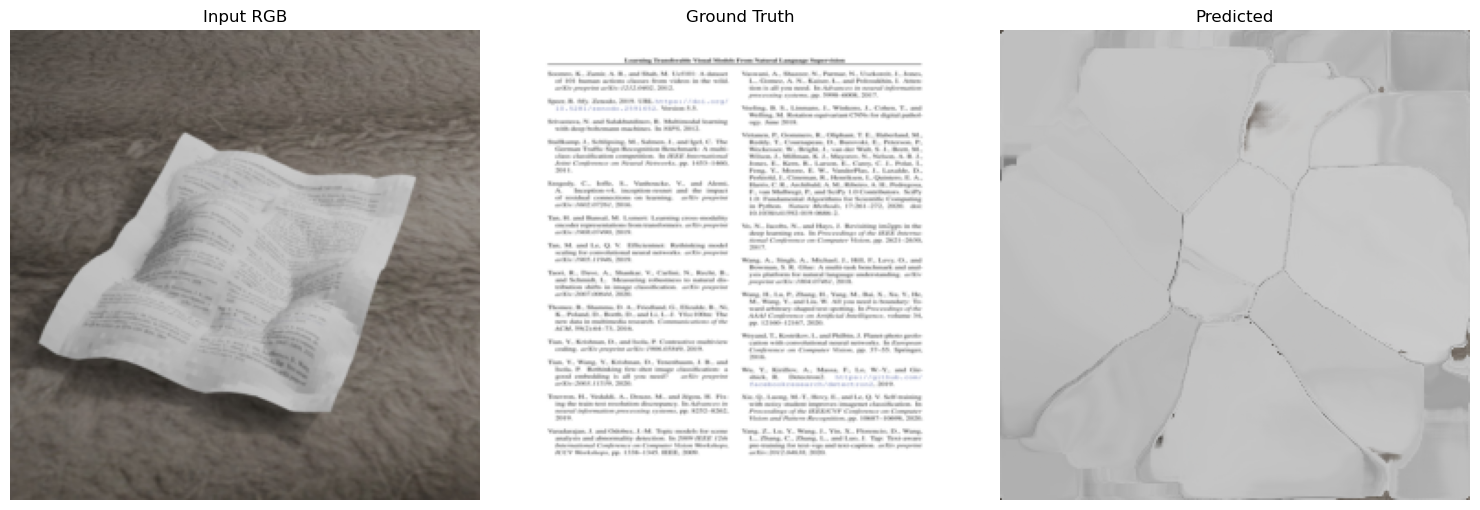

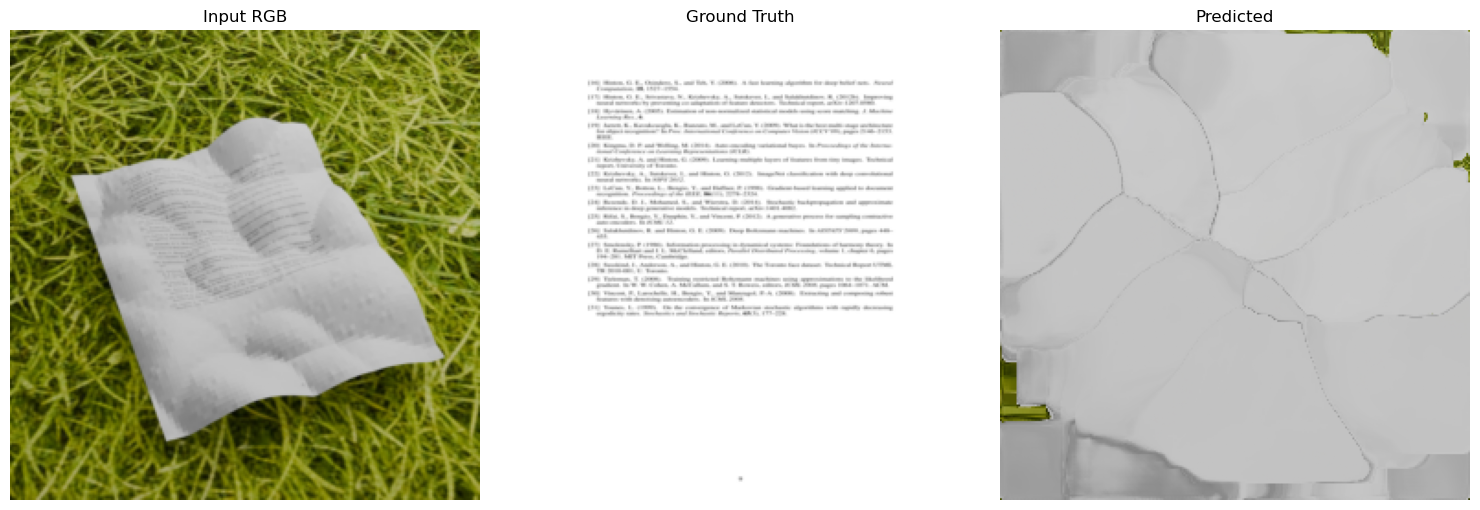

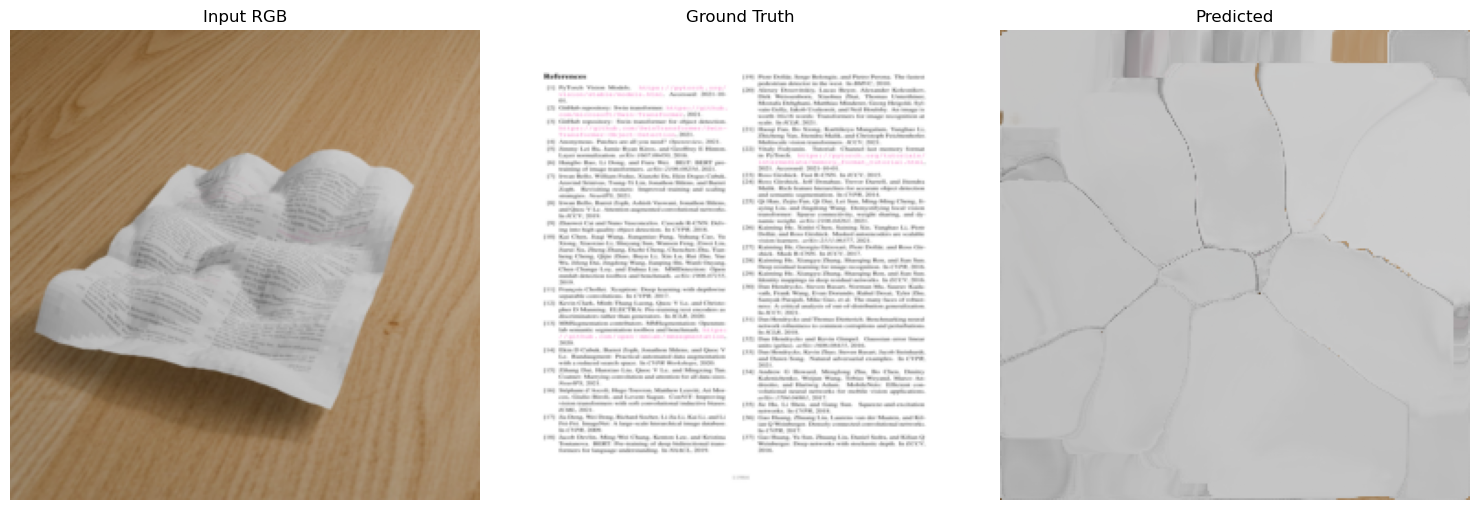

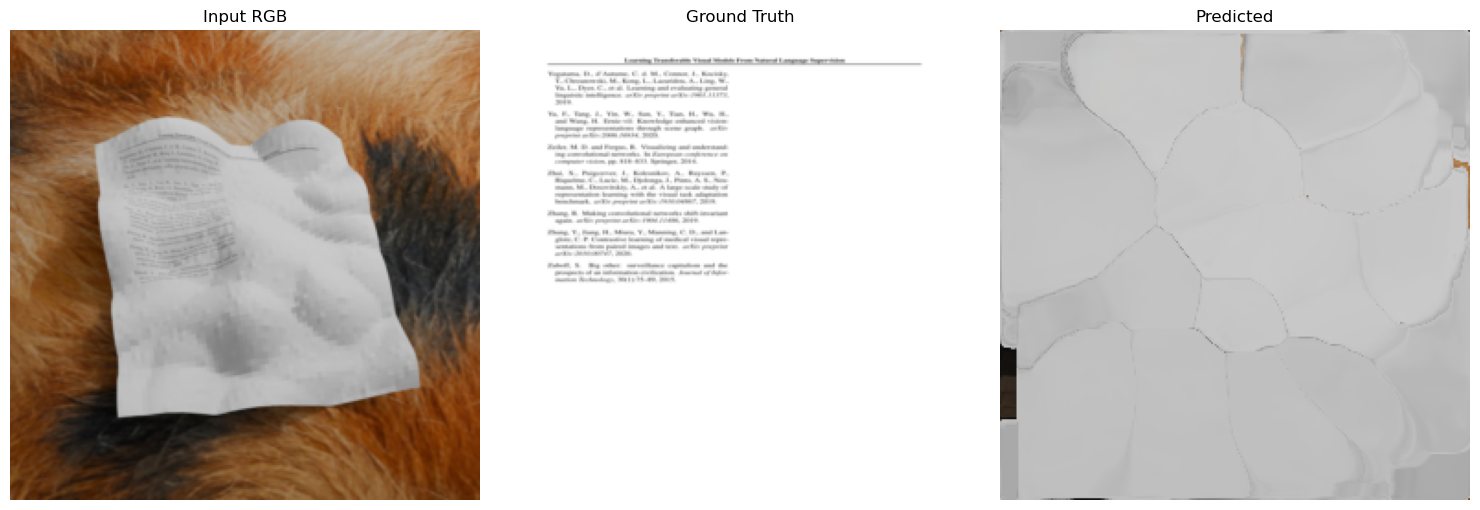

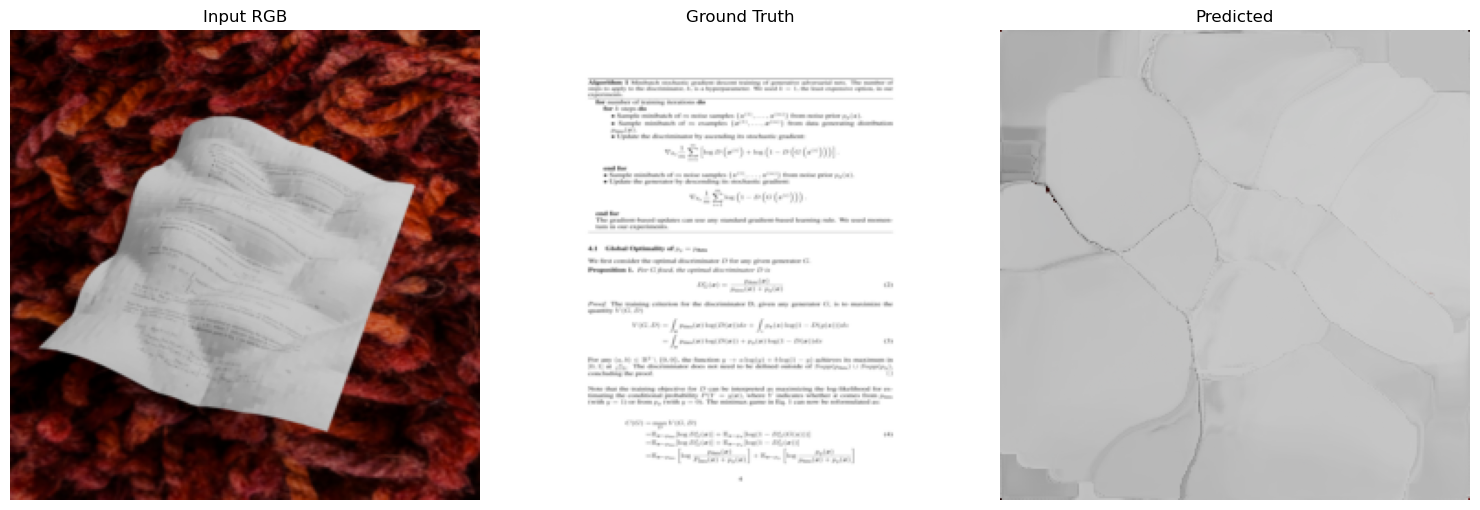

In [3]:
# Configuration
DATA_DIR = '/home/daniel-choate/Datasets/DocUnwarp/renders/synthetic_data_pitch_sweep'
BATCH_SIZE = 8
IMG_SIZE = (256, 256)
WEIGHTS_PATH = '../experiments/best_model.pth'
NUM_VISUALS = 5  # number of validation samples to visualize

# LOAD DATA
_, val_loader = get_dataloaders(
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    use_depth=False,
    use_uv=False,
    use_border=False
)

# Load device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load Model 
model = DocumentReconstructionModel().to(device)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))

# Loss function (ALTER IF NEEDED)
# criterion = nn.MSELoss()
criterion = SSIMLoss()

# Validation loss
val_loss = validate(model, val_loader, criterion, device)
print(f"Validation loss: {val_loss:.4f}")


# VISUALIZE PREDICTIONS
model.eval()
visualized = 0
with torch.no_grad():
    for batch in val_loader:
        rgb = batch['rgb'].to(device)
        gt = batch['ground_truth'].to(device)

        # Forward pass
        # output = model(rgb)
        output, flow = model(rgb)

        for i in range(rgb.size(0)):
            if visualized >= NUM_VISUALS:
                break

            visualize_batch_pred({
                'rgb': rgb[i].unsqueeze(0).cpu(),
                'ground_truth': gt[i].unsqueeze(0).cpu(),
                'predicted': output[i].unsqueeze(0).cpu()
            }, num_samples=1)

            visualized += 1

        if visualized >= NUM_VISUALS:
            break